## Importing libraries

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import random as rand
import py21cmfast as p21c

## Cosmological Parameters (Default is used when no input is specified)

In [88]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, etc.

In [89]:
BOX_LEN=300  # Box length
DIM=600      # Number of Voxels for hight resolution 
HII_DIM=300  # Number of Voxels for low resolution 

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,
    DIM=DIM,
    HII_DIM=HII_DIM
)

## Creating initial conditions box

In [90]:
init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params
)

## Plotting slices of Neutral fractions.

def simple_xH_plot(ion: p21c.outputs.IonizedBox, ax: plt.Axes):
    return ax.imshow(ion.xH_box[:, :, 0].T, extent=(0,200,0,200), vmin=0, vmax=1, origin='lower')

fig, ax = plt.subplots(2, 4, figsize=(14,6), sharex=True, sharey=True, gridspec_kw={"hspace":0.25, 'wspace': 0.05})

for i, z in enumerate([20, 12, 10, 9, 8, 7, 6, 5]):
    ion = p21c.ionize_box(redshift=z, init_boxes=init_cond)
    im = simple_xH_plot(ion, ax.flatten()[i])
    ax.flatten()[i].set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}")
    
cbar = plt.colorbar(im, ax=ax.ravel().tolist())
cbar.set_label("Neutral Fraction")

## Average Neutral Fraction vs. Redshift

lightcone = p21c.run_lightcone(
    redshift = 6,
    max_redshift = 8,
    init_box=init_cond,
    lightcone_quantities=(
        'brightness_temp',
        'xH_box',
    ),
    global_quantities=(
        'brightness_temp',
        'xH_box'
    )
)

p21c.plotting.plot_global_history(lightcone, kind='xH_box')
plt.title("Neutral Freaction vs. Redshift")

## Subject Ionized Box

z=6.5
ionized = p21c.ionize_box(
    redshift=z,
    init_boxes=init_cond
)
subject_box = ionized.xH_box
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond)

## Slice of Subject Box

plt.imshow(subject_box[:, :, 0], origin='lower')
plt.title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}")
plt.colorbar(label="Neutral Fraction")

## Square Blurring Function

In [204]:
def Square_Blurring(box, radius, iteration):
    box = box.copy()  # make copy of input box to have a separate box
    for i in range(iteration):
        np.random.seed()  # set seed to a randome number
        
        rand_coord = np.random.randint(radius, BOX_LEN-1-radius, size=3)  # ensure that the random center point won't be at the edge of the cube
        
        cube_region = box[rand_coord[0]-radius:rand_coord[0]+radius+1, rand_coord[1]-radius:rand_coord[1]+radius+1, rand_coord[2]-radius:rand_coord[2]+radius+1]
        
        neutral_mean = np.mean(cube_region)
        
        box[rand_coord[0]-radius:rand_coord[0]+radius+1, rand_coord[1]-radius:rand_coord[1]+radius+1, rand_coord[2]-radius:rand_coord[2]+radius+1] = neutral_mean
    return box

In [199]:
def Sphere_Blurring(box, radius, iteration):
    box = box.copy()  # make copy of input box to have a separate box
    for i in range(iteration):
        np.random.seed()  # set seed to a randome number
        
        rand_coord = np.random.randint(radius, BOX_LEN-1-radius, size=3)  # ensure that the random center point won't be at the edge of the cube
        
        print(rand_coord)
        
        cube_region = box[rand_coord[0]-radius:rand_coord[0]+radius+1, rand_coord[1]-radius:rand_coord[1]+radius+1, rand_coord[2]-radius:rand_coord[2]+radius+1]
        
        keys_index_x = np.arange(np.shape(cube_region)[0])
        keys_index_y = np.arange(np.shape(cube_region)[1])
        keys_index_z = np.arange(np.shape(cube_region)[2])
        
        keys_x, keys_y, keys_z = np.meshgrid(keys_index_x, keys_index_y, keys_index_z, indexing='ij')

        dist_frm_centr = np.sqrt((keys_x-rand_coord[0])**2 + (keys_y-rand_coord[1])**2 + (keys_z-rand_coord[2])**2)
        
        sphere_condition =  dist_frm_centr <= radius
        sphere_condition1 =  dist_frm_centr <= 0.25*radius
        sphere_condition2 =  np.logical_and(dist_frm_centr <= 0.5*radius, dist_frm_centr > 0.25*radius)
        sphere_condition3 =  np.logical_and(dist_frm_centr <= 0.75*radius, dist_frm_centr > 0.5*radius)
        sphere_condition4 =  np.logical_and(dist_frm_centr <= radius, dist_frm_centr > 0.75*radius)
        
        inside_sphere_mean = np.mean(cube_region[sphere_condition])
        
        cube_region = np.where(sphere_condition, inside_sphere_mean, 0)
#         cube_region = np.where(sphere_condition1, inside_sphere_mean, cube_region)
#         cube_region = np.where(sphere_condition2, 0.75*inside_sphere_mean, cube_region)
#         cube_region = np.where(sphere_condition3, 0.5*inside_sphere_mean, cube_region)
#         cube_region = np.where(sphere_condition4, 0.25*inside_sphere_mean, cube_region)
        
        box[rand_coord[0]-radius:rand_coord[0]+radius+1, rand_coord[1]-radius:rand_coord[1]+radius+1, rand_coord[2]-radius:rand_coord[2]+radius+1] = cube_region  
    return box

In [94]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label="Neutral Fraction")
    plt.sca(last_axes)
    return cbar

In [95]:
z = 6.5
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box

In [205]:
Sphere_blurred = Square_Blurring(box=np.random.rand(299,299,299), radius=140, iteration=1)

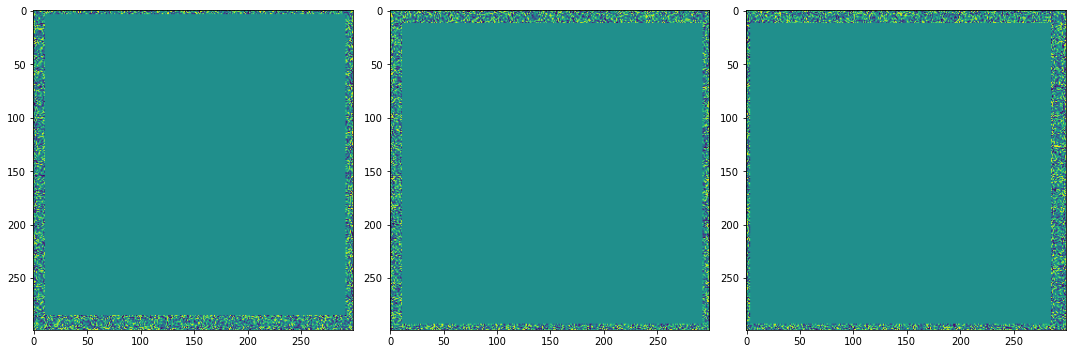

In [206]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,15))

img1 = ax1.imshow(Sphere_blurred[149,:,:])

img2 = ax2.imshow(Sphere_blurred[:,149,:])

img3 = ax3.imshow(Sphere_blurred[:,:,149])

plt.tight_layout(h_pad=1)

z = 6.5
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(ionized[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax1.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax1.set_ylabel("y [voxel]")
ax1.set_xlabel("x [voxel]")
colorbar(img1)


img2 = ax2.imshow(Square_Blurring(ionized, radius=6, iteration=10**7)[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax2.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax2.set_xlabel("x [voxel]")
colorbar(img2)

plt.tight_layout(h_pad=1)

z = 6.5
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(ionized[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax1.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax1.set_ylabel("y [voxel]")
ax1.set_xlabel("x [voxel]")
colorbar(img1)


img2 = ax2.imshow(Square_Blurring(ionized, radius=13, iteration=10**6)[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax2.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax2.set_xlabel("x [voxel]")
colorbar(img2)

plt.tight_layout(h_pad=1)

[142 149 153]


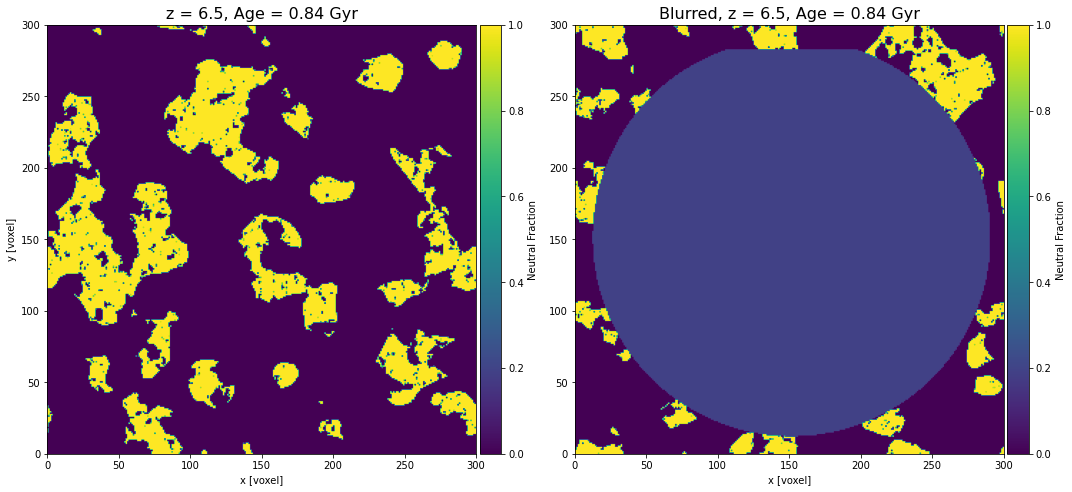

In [99]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(ionized[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax1.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax1.set_ylabel("y [voxel]")
ax1.set_xlabel("x [voxel]")
colorbar(img1)


img2 = ax2.imshow(Sphere_Blurring(ionized, 140, 1)[:, :, 150], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax2.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax2.set_xlabel("x [voxel]")
colorbar(img2)

plt.tight_layout(h_pad=1)

test_box = np.random.rand(101,101,101)
test_center = [0.5*(np.shape(test_box)[0]-1), 0.5*(np.shape(test_box)[1]-1), 0.5*(np.shape(test_box)[2]-1)]

true_false_index_x = np.arange(np.shape(test_box)[0])
true_false_index_y = np.arange(np.shape(test_box)[1])
true_false_index_z = np.arange(np.shape(test_box)[2])
test_x, test_y, test_z = np.meshgrid(true_false_index_x, true_false_index_y, true_false_index_z)

circle_condition = np.sqrt((test_x - test_center[0])**2 + (test_y - test_center[1])**2 + (test_z - test_center[2])**2) <= 30
inside_circle_mean = np.mean(test_box[circle_condition])
test_box = np.where(circle_condition, inside_circle_mean, test_box)

plt.imshow(test_box[:,:,21])

np.shape(test_box)[0]

x_values = np.arange(20)
condition = np.logical_and(7 <= x_values, x_values <= 14)
x_values[condition]

x = np.arange(20)
avg_1 = x[np.logical_and(7 <= x, x <= 14)].mean()
avg_2 = np.where(np.logical_and(7 <= x, x <= 14), x, 0).mean()
avg_1 == avg_2



U, V = Square_Blurring(ionized, 30, 10**3)
print(V)

x = np.arange(100).reshape(10,10)
print(x)
x[3:7,1:5] = np.where(x[3:7,1:5] % 2, 0, x[3:7,1:5])
print(x)

# start with a 100 x 100 square grid
Nside = 100
base_indices = np.arange(Nside)
x_indices, y_indices = np.meshgrid(base_indices, base_indices)
reference_position_indices = np.array([37, 20])
# disk = np.where(np.sqrt((x_indices - reference_position_indices[0])**2 + (y_indices - reference_position_indices[1])**2)<= 10, 1, 0)
np.sqrt((x_indices - reference_position_indices[0])**2 + (y_indices - reference_position_indices[1])**2)<= 10
plt.imshow(disk)

square = np.where(np.logical_and(np.abs(x_indices - reference_position_indices[0]) <= 5, np.abs(y_indices - reference_position_indices[1]) <= 5), 1, 0)
plt.imshow(square)

conditional_array = [True,] * 5 + [False,] * 5
positive_integers = np.arange(len(conditional_array))
negative_integers = -positive_integers
test_result = np.where(conditional_array, positive_integers, negative_integers)
print(positive_integers)

## Blurring the Subject Box

blurred_box = Square_Blurring(subject_box, 1, 10**7)

## Plotting

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(blurred_box[:, :, 0], origin='lower')
ax1.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
colorbar(img1)

img2 = ax2.imshow(subject_box[:, :, 0], origin='lower')
ax2.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
colorbar(img2)

plt.tight_layout(h_pad=1)

ionized is Sphere_blurred

LEN = 5
A = np.zeros((LEN,LEN,LEN))

center_x = 0.5*(LEN-1)
center_y = 0.5*(LEN-1)
center_z = 0.5*(LEN-1)
Radius = 2
for xx in range(LEN):
    for yy in range(LEN):
        for zz in range(LEN):
            dist = np.sqrt((xx - center_x)**2 + (yy - center_y)**2 + (zz - center_z)**2)
            if dist <= Radius:
                A[xx, yy, zz] = 1
print(A)
print(np.sum(A))
print(center_x)
plt.imshow(A[np.int(center_x),:,:])